# Coupled qubits and resonator

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from torchqc.states import QuantumState
from torchqc.common_functions import get_density_matrix, fidelity
from torchqc.operators import DynamicOperator
from torchqc.common_matrices import annihilation, creation, eye, sigmaMinus, sigmaPlus
from torchqc.dynamics import lindblad_equation
from torchqc.tensor_product import tensor_product_ops, tensor_product_states, partial_trace

* Start from basis state $\psi_0 \otimes \phi_2$

In [12]:
N = 6 # resonator modes
n = 2
# tensor product of two qubits and a resonator mode
total_dims = (n ** 3) * N

qubit_states_basis = QuantumState.basis(n)
resonator_basis_states = QuantumState.basis(N)

qubit1_state = qubit_states_basis[0]
qubit2_state = qubit_states_basis[1]
qubit3_state = qubit_states_basis[0]
resonator_state = resonator_basis_states[0]

initial_state = tensor_product_states(qubit1_state, qubit2_state, qubit3_state, resonator_state)

In [13]:
target_state = (1 / np.sqrt(2)) * (tensor_product_states(qubit_states_basis[0], qubit_states_basis[0], qubit_states_basis[0]) + tensor_product_states(qubit_states_basis[1], qubit_states_basis[1], qubit_states_basis[1]))

In [14]:
qubit_prod_state = partial_trace(get_density_matrix(initial_state), [3])
qubit_prod_state

Operator (dims = 8, tensor: tensor([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
       dtype=torch.complex128))

* System parameters

In [15]:
T = 4
Dt = 0.02
time = np.arange(0, T, Dt, dtype = np.float32)
g1 = 10
g2 = 1
g3 = 10
ξ = 20

* System Hamiltonian

In [16]:
a_dagger = creation(N)
a = annihilation(N)
sm = sigmaMinus()
sp = sigmaPlus()

H1 = g1 * tensor_product_ops(sm, eye(n), eye(n), a_dagger) + tensor_product_ops(sp, eye(n), eye(n), a) \
    + g2 * tensor_product_ops(eye(n), sm, eye(n), a_dagger) + tensor_product_ops(eye(n), sp, eye(n), a) \
        + g3 * tensor_product_ops(eye(n), eye(n), sm, a_dagger) + tensor_product_ops(eye(n), eye(n), sp, a)

H2 = ξ * tensor_product_ops(eye(n), eye(n), eye(n), a_dagger + a)

H = H1 + H2

In [17]:
hamiltonian = DynamicOperator(total_dims, H, time=time)

* Simulate dynamics with von-Neumann equation

In [18]:
jump_ops = []
rates = []

rho = get_density_matrix(initial_state)
time_tensor, states = lindblad_equation(rho, hamiltonian, time, Dt, jump_ops, rates, method="rk45")

In [19]:
import torch

fidelities = torch.tensor([fidelity(partial_trace(state, [3]), get_density_matrix(target_state)) for state in states])

* Plot results

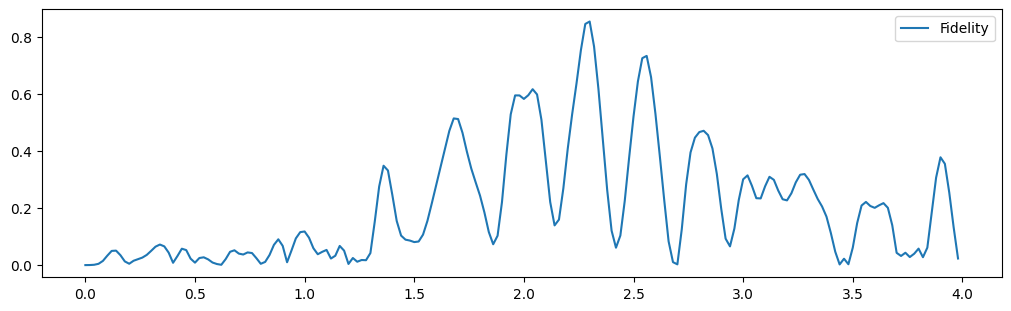

In [20]:
fig, ax = plt.subplots(layout='constrained')
fig.set_figwidth(10)
fig.set_figheight(3)

ax.plot(time, fidelities, label=r"Fidelity")
ax.legend()